<a href="https://colab.research.google.com/github/BeckhamB/AIClassification/blob/main/Transfer_Learning_%2B_Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## **Testing neural network + testing using transfer learning**


In [136]:
pip install split-folders[full]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [137]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [138]:
!unzip '/content/gdrive/MyDrive/arctic_dataset.zip' > /dev/null

replace arctic_dataset/bear/_113530377_bears_kt-miller.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [139]:
import splitfolders

splitfolders.ratio("arctic_dataset", output="split_arctic_dataset",
                   seed=1337, ratio=(.7, .15, .15), group_prefix=None, move=False)

Copying files: 642 files [00:00, 2165.32 files/s]


In [140]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

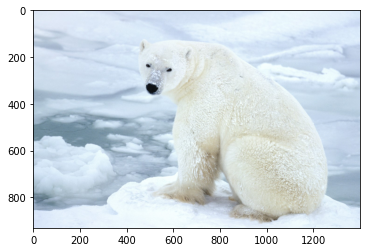

In [141]:
image = mpimg.imread('/content/split_arctic_dataset/train/bear/3_2_image.jpg')
plt.imshow(image)
plt.show()

In [142]:
# import libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print('CUDA is not available. Training on CPU.')
else:
  print('CUDA is available. Training on GPU.')

CUDA is available. Training on GPU.


In [143]:
# imshow function for displaying images
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [144]:
# dataset directory
data_dir = 'split_arctic_dataset'

# define batch size
batch_size = 6

# define transforms (colour)
transform = transforms.Compose([transforms.Resize(32), # resize to 32x?
                                transforms.CenterCrop(32), # take a square (32x32) crop from the centre
                                transforms.ToTensor(), # convert data to torch.FloatTensor
                                transforms.Normalize([0.5, 0.5, 0.5],
                                                     [0.5, 0.5, 0.5])]) # normalise with mean 0.5 and standard deviation 0.5 for each colour channel

# choose the training, validation and test datasets
train_data = datasets.ImageFolder(data_dir + '/train', transform=transform)
val_data = datasets.ImageFolder(data_dir + '/val', transform=transform)
test_data = datasets.ImageFolder(data_dir + '/test', transform=transform)

# prepare the data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True)

torch.Size([6])


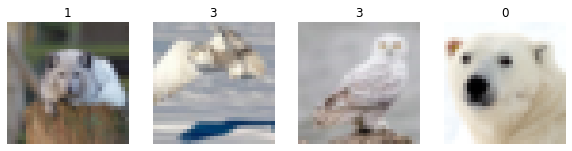

In [145]:
# obtain one batch of training images
data_iter = iter(train_loader)
images, labels = next(data_iter)

print(labels.shape)

# plot the first 4 images in the batch, along with the corresponding labels
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    imshow(images[ii], ax=ax, normalize=True)
    ax.set_title(str(labels[ii].item())) 
# 0 is Bears, 1 is Foxes, 2 is Hares, 3 is Owls, 4 is Wolves

In [146]:
#########################################################################
# here we define our CNN architecture
#########################################################################

import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer 1 (input 32x32x3)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) # torch.nn.Conv2d(in_channels, out_channels, kernel_size)
        # convolutional layer 2 (input 16x16x16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer 3 (input 8x8x32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer 
        self.pool = nn.MaxPool2d(2, 2) # torch.nn.MaxPool2d(kernel_size, stride)
        # fully connected layer 1 (input 4x4x64)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        # fully connected layer 2 (input 500, output 5 - four classes)
        self.fc2 = nn.Linear(500, 5) 
        # dropout layer
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 64 * 4 * 4)
        # dropout layer
        x = self.dropout(x)
        # hidden layer and relu
        x = F.relu(self.fc1(x))
        # dropout layer
        x = self.dropout(x)
        # add output layer
        x = self.fc2(x)
        
        return x

# create the CNN
model = Net()
print(model)

#########################################################################
#########################################################################

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=5, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [147]:
import torch.optim as optim

# specify loss function (cross entropy loss)
criterion = nn.CrossEntropyLoss()
# specify optimizer (Adam optimiser) and learning rate = 0.003
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [148]:
# number of epochs to train the model
n_epochs = 10

# initialise tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

# create empty lists to store the training and validation losses
train_losses, val_losses = [], []

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data, target in val_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item()*data.size(0)
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(val_loader.sampler)

    # store the training and validation losses for later visualisation
    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'CNN_model.pt') # save in colab
        torch.save(model.state_dict(), '/content/gdrive/MyDrive/CNN_model.pt') # save in google drive
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.606107 	Validation Loss: 1.588699
Validation loss decreased (inf --> 1.588699).  Saving model ...
Epoch: 2 	Training Loss: 1.583691 	Validation Loss: 1.552505
Validation loss decreased (1.588699 --> 1.552505).  Saving model ...
Epoch: 3 	Training Loss: 1.548938 	Validation Loss: 1.514195
Validation loss decreased (1.552505 --> 1.514195).  Saving model ...
Epoch: 4 	Training Loss: 1.525311 	Validation Loss: 1.492264
Validation loss decreased (1.514195 --> 1.492264).  Saving model ...
Epoch: 5 	Training Loss: 1.478176 	Validation Loss: 1.450384
Validation loss decreased (1.492264 --> 1.450384).  Saving model ...
Epoch: 6 	Training Loss: 1.424078 	Validation Loss: 1.422792
Validation loss decreased (1.450384 --> 1.422792).  Saving model ...
Epoch: 7 	Training Loss: 1.375941 	Validation Loss: 1.391689
Validation loss decreased (1.422792 --> 1.391689).  Saving model ...
Epoch: 8 	Training Loss: 1.345970 	Validation Loss: 1.380038
Validation loss decreased (1.39168

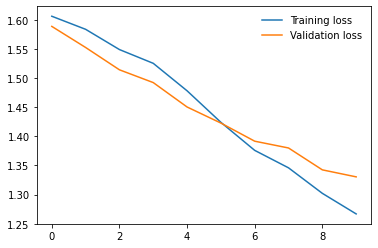

In [149]:
# Visualise the training and validation losses over time
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)

In [150]:
# Load the Model with the Lowest Validation Loss
model.load_state_dict(torch.load('CNN_model.pt'))

<All keys matched successfully>

In [151]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(5):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.293840

Test Accuracy of     0: 78% (15/19)
Test Accuracy of     1: 26% ( 5/19)
Test Accuracy of     2: 52% ( 9/17)
Test Accuracy of     3: 16% ( 4/24)
Test Accuracy of     4: 71% (15/21)

Test Accuracy (Overall): 48% (48/100)


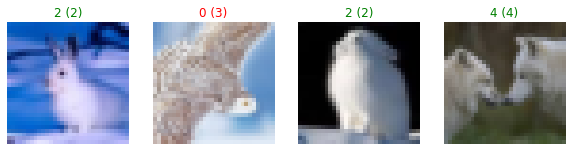

In [152]:
# Visualize Sample Test Results

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)

# plot the first 4 images in the batch, along with the corresponding labels
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    imshow(images[ii], ax=ax, normalize=True)
    ax.set_title("{} ({})".format(str(preds[ii].item()), str(labels[ii].item())),
                 color=("green" if preds[ii]==labels[ii] else "red")) 
# 0 is Bears, 1 is Foxes, 2 is Hares, 3 is Owls, 4 is Wolves

Transfer Learning

In [154]:
# dataset directory
data_dir = 'split_arctic_dataset'

# define batch size
batch_size = 6

# define transforms
# training (with random flips and rotation)
train_transform = transforms.Compose([transforms.Resize(236), # resize to 236x?
                                transforms.RandomRotation(5), # random rotation
                                transforms.CenterCrop(224), # take a square (224x224) crop from the centre
                                transforms.RandomHorizontalFlip(), # randomly flip on horizontal axis
                                transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5,hue=0.5),
                                transforms.ToTensor(), # convert data to torch.FloatTensor
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])]) # normalise for each colour channel

# validation and testing
transform = transforms.Compose([transforms.Resize(224), # resize to 224x?
                                transforms.CenterCrop(224), # take a square (224x224) crop from the centre
                                transforms.ToTensor(), # convert data to torch.FloatTensor
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])]) # normalise for each colour channel

# choose the training, validation and test datasets
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transform)
val_data = datasets.ImageFolder(data_dir + '/val', transform=transform)
test_data = datasets.ImageFolder(data_dir + '/test', transform=transform)

# prepare the data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True)

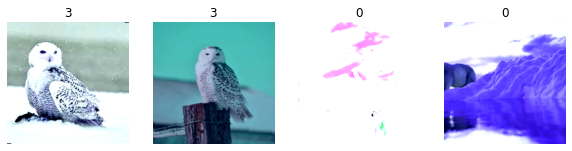

In [155]:
# obtain one batch of training images
data_iter = iter(train_loader)
images, labels = next(data_iter)

# plot the first 4 images in the batch, along with the corresponding labels
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    imshow(images[ii], ax=ax, normalize=True)
    ax.set_title(str(labels[ii].item())) 
# 0 is Bears, 1 is Foxes, 2 is Hares, 3 is Owls, 4 is Wolves

In [156]:
#########################################################################
# use a ResNet18 network
# #########################################################################
# NB This network requires an image input size of 3x224x224 and normalised using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

import torch.nn as nn
import torchvision.models as models

# load a pre-trained ResNet network with 18 layers
model = models.resnet50(pretrained=True)

# # if we use the following code the pre-trained weights are frozen and we only update the final layer
# for param in model.parameters():
#     param.requires_grad = False

# get the number of inputs for the final layer (fc) of the network
num_ftrs = model.fc.in_features
# replace the final layer so that the output is number of classes
model.fc = nn.Linear(num_ftrs, 5)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

print(model)

# #########################################################################
# #########################################################################

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [157]:
import torch.optim as optim

# specify loss function (cross entropy loss)
criterion = nn.CrossEntropyLoss()
# specify optimiser (Adam optimiser) and learning rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [158]:
# number of epochs to train the model
n_epochs = 30

# initialise tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

# create empty lists to store the training and validation losses
train_losses, val_losses = [], []

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data, target in val_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item()*data.size(0)
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(val_loader.sampler)

    # store the training and validation losses for later visualisation
    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'resnet18_model_fine_tune_aug.pt') # save in colab
        torch.save(model.state_dict(), '/content/gdrive/MyDrive/resnet18_model_fine_tune_aug.pt') # save in google drive
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.742652 	Validation Loss: 0.316911
Validation loss decreased (inf --> 0.316911).  Saving model ...
Epoch: 2 	Training Loss: 0.518547 	Validation Loss: 0.248048
Validation loss decreased (0.316911 --> 0.248048).  Saving model ...
Epoch: 3 	Training Loss: 0.301444 	Validation Loss: 0.192552
Validation loss decreased (0.248048 --> 0.192552).  Saving model ...
Epoch: 4 	Training Loss: 0.281490 	Validation Loss: 0.243669
Epoch: 5 	Training Loss: 0.295808 	Validation Loss: 0.719780
Epoch: 6 	Training Loss: 0.264313 	Validation Loss: 0.320720
Epoch: 7 	Training Loss: 0.236147 	Validation Loss: 0.245354
Epoch: 8 	Training Loss: 0.155227 	Validation Loss: 0.235486
Epoch: 9 	Training Loss: 0.175678 	Validation Loss: 0.244505
Epoch: 10 	Training Loss: 0.083734 	Validation Loss: 0.236223
Epoch: 11 	Training Loss: 0.131984 	Validation Loss: 0.362652
Epoch: 12 	Training Loss: 0.113677 	Validation Loss: 0.301408
Epoch: 13 	Training Loss: 0.118676 	Validation Loss: 0.253026
E

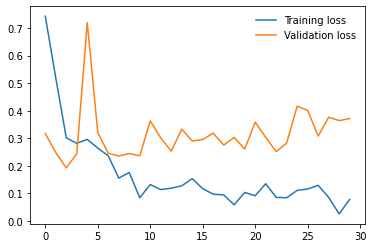

In [159]:
# visualise the training and validation losses over time
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)

In [160]:
# Load the Model with the Lowest Validation Loss
model.load_state_dict(torch.load('resnet18_model_fine_tune_aug.pt'))

<All keys matched successfully>

In [161]:
# Test the Trained Network

# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

# change value here to number of classes
for i in range(5):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.124615

Test Accuracy of     0: 94% (18/19)
Test Accuracy of     1: 94% (18/19)
Test Accuracy of     2: 94% (16/17)
Test Accuracy of     3: 95% (23/24)
Test Accuracy of     4: 100% (21/21)

Test Accuracy (Overall): 96% (96/100)


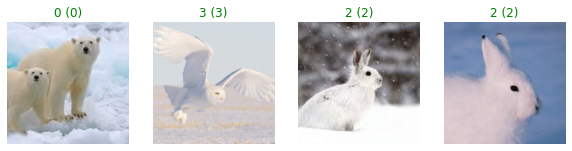

In [166]:
# Visualize Sample Test Results

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the first 4 images in the batch, along with the corresponding labels
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    imshow(images.cpu()[ii], ax=ax, normalize=True)
    ax.set_title("{} ({})".format(str(preds[ii].item()), str(labels[ii].item())),
                 color=("green" if preds[ii]==labels[ii] else "red")) 
# 0 is Bears, 1 is Foxes, 2 is Hares, 3 is Owls, 4 is Wolves

In [163]:
# imshow function for displaying images
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax